# <center>M2 DAC -   Reinforcement Learning & Advanced Deep</center>
##  <center> TME 9. Generative Adversarial Networks  </center>

Ce TME a pour objectif d'expérimenter les Generative Adversarial Networks (GANs) sur un problème de génération de visages. 

De manière classique, un GAN se formule selon un problème adverse de la manière suivante: 
$$\min\limits_{G} \max\limits_D V(D,G) = \mathbb{E}_{x\sim p_{data}(x)}\big[logD(x)\big] + \mathbb{E}_{z\sim p_{z}(z)}\big[log(1-D(G(z)))\big]$$
Cette formulation met en jeu deux réseaux adverse: 
*   Un réseau discriminateur $D$, dont l'objectif est de savoir distinguer les données réelles des données simulées  
*   Un réseau générateur $G$, dont l'objectif est de flouer le discriminateur

À l'optimum, avec des réseaux de capacité infinie, la distribution $p_G$ des données générées par $G$ est prouvée suivre la distribution des données réelles $p_{data}$. Bien sûr nous ne travaillons pas avec des réseaux de capacité infinie (et d'ailleurs heureusement car on ne veut pas apprendre par coeur les données d'apprentissage), mais l'objectif est d'approcher cette distribution $p_{data}$ en apprenant un générateur neuronal dont les sorties sont difficilement distinguables des vraies données pour le discriminateur. 

Nous proposons de mettre ce genre d'architecture pour un la génération de visages: selon un ensemble de visages d'entraînement, il s'agit d'apprendre à générer des visages qui paraissent les plus réalistes possibles tout en conservant une certaine diversité dans les distributions de sortie. Pour cela nous emploierons une architecture DCGAN, qui utilise des réseaux de neurones convolutionnels (CNNs) pour le générateur et le discriminateur.    


 



Pour ce TP, nous vous proposons de travailler avec Google Colab qui est un service notebook en ligne avec ressources machines à disposition (nécessite d'être connecté à un compte google personnel):
*   https://colab.research.google.com/
*   Ouvrir ce Notebook avec "File>Upload Notebook"
*   Sélectionner un Runtime GPU : Runtime>Change Runtime Type (utile de le faire avant tout téléchargement de données car le changement de Runtime efface les données temporaires de la session)

Pour télécharger les données utiles au TP: 


*   Aller à l'adresse : https://drive.google.com/open?id=0B7EVK8r0v71pWEZsZE9oNnFzTm8
*   Clic-droit sur CelebA, Ajouter à mon Drive
*   Exécuter le code ci-dessous (une autorisation vous sera demandée, suivre le lien donné à l'exécution pour obtenir le code d'authentification)

(Sinon vous pouvez aussi travailler en local en téléchargeant les données sur votre ordinateur mais attention fichier volumineux et colab propose des ressources GPU utiles à la résolution du TP)

Vous devez maintenant avoir dans le paneau de gauche un onglet Files contenant un répertoire drive dans l'arborescence. C'est votre espace de stockage Google Drive. Il devrait contenir un répertoire CelebA (si ce n'est pas le cas attendre un peu et rafraichir, il peut mettre un certain temps à apparaître). 

Il s'agit maintenant de décompresser l'archive téléchargée (cela peut prendre jusqu'à une dizaine de minutes): 



In [1]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    !pip3 install natsort

In [2]:

import numpy as np
try:
    import torch
except:
    #!pip3 install torch==1.2.0+cu92 torchvision==0.4.0+cu92 -f https://download.pytorch.org/whl/torch_stable.html
    import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.utils.data
import torchvision.datasets as dset
import torchvision.utils as vutils
import torch.backends.cudnn as cudnn    

In [3]:
from __future__ import print_function
%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


Le code ci-dessous permet de déclarer la manière de charger les données. 

Lorsque des données sont demandées (pour la construction d'un nouveau batch par exemple), une série de transformations est appliquée sur les images, selon la composition de transformateurs déclarée pour le chargement: 
*    redimentionnement des images en 64 par 64
*    recadrage au centre (qui ne fait rien ici car image déjà dans la taille du cadre mais si utile pour d'autres paramètres)
*    conversion en tenseur pytorch 
*    normalisation des valeurs RGB selon une moyenne de 0.5 et un ecart-type de 0.5.



In [4]:
import os
import zipfile 
import torch
from natsort import natsorted
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms

## Setup
# Number of gpus available
ngpu = 1
device = torch.device('cuda:0' if (
    torch.cuda.is_available() and ngpu > 0) else 'cpu')



## Create a custom Dataset class
class CelebADataset(Dataset):
  def __init__(self, root_dir, transform=None):
    """
    Args:
      root_dir (string): Directory with all the images
      transform (callable, optional): transform to be applied to each image sample
    """
    # Read names of images in the root directory
    image_names = os.listdir(root_dir)

    self.root_dir = root_dir
    self.transform = transform 
    self.image_names = natsorted(image_names)

  def __len__(self): 
    return len(self.image_names)

  def __getitem__(self, idx):
    # Get the path to the image 
    img_path = os.path.join(self.root_dir, self.image_names[idx])
    # Load image and convert it to RGB
    img = Image.open(img_path).convert('RGB')
    # Apply transformations to the image
    if self.transform:
      img = self.transform(img)

    return img

## Load the dataset 
# Path to directory with all the images
img_folder = f"/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba"
# Spatial size of training images, images are resized to this size.
image_size = 64
# Transformations to be applied to each individual image sample
transform=transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                          std=[0.5, 0.5, 0.5])
])
# Load the dataset from file and apply transformations
celeba_dataset = CelebADataset(img_folder, transform)

## Create a dataloader 
# Batch size during training
batch_size = 128
# Number of workers for the dataloader
num_workers = 0 if device.type == 'cuda' else 2
# Whether to put fetched data tensors to pinned memory
pin_memory = True if device.type == 'cuda' else False

celeba_dataloader = torch.utils.data.DataLoader(celeba_dataset,
                                                batch_size=batch_size,
                                                num_workers=num_workers,
                                                pin_memory=pin_memory,
                                                shuffle=True)

In [5]:
len(celeba_dataset)

202599

In [6]:
im = celeba_dataset.__getitem__(0)
im.size()

torch.Size([3, 64, 64])

In [7]:
device, torch.cuda.get_device_name(0)

(device(type='cuda', index=0), 'Tesla P100-PCIE-16GB')

Le code ci-dessous permet de déclarer la manière de charger les images et en affiche un échantillon. 

Le réseau $D$ est un empilement de couches de convolution 2D avec batchNorm2D et activations RELU: 

In [8]:


nc = 3 # Nombre de canaux de l'entrée
ndf = 64 # Facteur du nombre de canaux de sortie des différentes couches de convolution


# Initialisation recommandee pour netG et netD dans DCGAN
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input).view(-1)


netD = Discriminator().to(device)
netD.apply(weights_init)
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [9]:
nz=100  #Taille du vecteur z donné en entrée du générateur
ngf = 64 # Facteur du nombre de canaux de sortie des différentes couches de deconvolution

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution, size nzx1x1
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)
netG = Generator().to(device)
netG.apply(weights_init)
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


Donner la procédure d'entraînement de ces deux réseaux. L'optimisation se fera ADAM selon les deux coûts adverses du discriminateur et du générateur. Pour chaque nouveau batch d'images, on alterne les deux mises à jour suivantes, selon un batch de vecteurs $z$ tirés aléatoirement selon une loi normale centrée réduite (un nouveau batch de $z$ à chaque itération): 

1.   Un pas de gradient sur les paramètres du réseau D pour maximiser:  $log(D(x)) + log(1 - D(G(z)))$
2.   Un pas de gradient sur les paramètres du réseau G pour maximiser:  $log(D(G(z)))$ 

3.   $D = \frac{p_{data}(x)}{p_{data}(x) + p_{gen}(x)}$ best is $\frac{1}{2}$, if generated date is the same as original data.


Afin de suivre l'évolution de l'apprentissage, on pourra logguer l'erreur du discriminateur relevée en 1, l'erreur du générateur relevée en 2, la moyenne des sorties du discriminateur sur les images réelles et la moyenne des sorties du discriminateur sur les images générées.

À la fin de chaque époque (i.e., lorsque l'on a itéré sur tous les batchs du DataLoader), on pourra enregistrer les images générées à partir d'un batch de vecteurs $z$ fixe dans le Google Drive pour observer l'évolution des capacités du générateur.  



In [10]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [11]:
import math
import itertools
def generate_images(epoch, path, fixed_noise, num_test_samples, netG, device, use_fixed=True):

    z = torch.randn(num_test_samples, 100, 1, 1, device=device)
    size_figure_grid = int(math.sqrt(num_test_samples))
    title = None
  
    if use_fixed:
        generated_fake_images = netG(fixed_noise)
        path += 'fixed_noise/'
        title = 'Fixed Noise'
    else:
        generated_fake_images = netG(z)
        path += 'variable_noise/'
        title = 'Variable Noise'
    
    if not os.path.exists(path):
        os.makedirs(path)
    
    fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(6,6))
    for i, j in itertools.product(range(size_figure_grid), range(size_figure_grid)):
        ax[i,j].get_xaxis().set_visible(False)
        ax[i,j].get_yaxis().set_visible(False)
    for k in range(num_test_samples):
        i = k//4
        j = k%4
        ax[i,j].cla()
        ax[i,j].imshow((generated_fake_images[k].cpu().data.numpy().transpose(1, 2, 0) + 1) / 2 )
    label = 'Epoch_{}'.format(epoch+1)
    fig.text(0.5, 0.04, label, ha='center')
    fig.suptitle(title)
    fig.savefig(path+label+'.png')

In [12]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.


In [13]:
import time

def train(epoch, data_train, netG, netD, opt_D,opt_G, writer, device,max_epochs):
    loss_meter = AverageMeter()
    iter = epoch * len(data_train)
    netG.train()
    netD.train()
    t=time.time()
    for batch in data_train:
        batch=batch.to(device)

        opt_D.zero_grad()
        # Forward pass real batch through D
        label = torch.full((batch.shape[0],), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(batch)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        p_data = output.mean().cpu().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        sample = torch.randn(batch.shape[0], nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(sample)

        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach())
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        opt_D.step()

        p_gen = output.mean().item()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        opt_G.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        opt_G.step()
              
        # Loss Function
        loss=p_data/(p_data+p_gen)
        loss_meter.update(loss)
        '''
        # Optimiser
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        '''
        iter += 1
        writer.add_scalar("Train/Loss", loss, iter)
        writer.add_scalar("Discriminator Loss", errD, iter)
        writer.add_scalar("Generator Loss", errG, iter)
        writer.add_scalar("Pred_Disc/Real", p_data, iter)
        writer.add_scalar("Pred_Disc/Fake", p_gen, iter)


        if iter % 100 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f'
                  % (epoch, max_epochs, iter, (1+epoch) * len(data_train),
                     errD.item(), errG.item(), p_data, p_gen))
   

    writer.add_scalar("Train/Epoch Loss", loss_meter.avg, epoch)
    print(loss_meter.avg, epoch)
    print("Time for EPOCH: %.3f" % ((time.time()-t)/60))
    
    

In [14]:
device


device(type='cuda', index=0)

[0/20][100/1583]	Loss_D: 0.0810	Loss_G: 5.2818	D(x): 0.9964	D(G(z)): 0.0645


[0/20][200/1583]	Loss_D: 0.1120	Loss_G: 5.3055	D(x): 0.9423	D(G(z)): 0.0331


[0/20][300/1583]	Loss_D: 0.1709	Loss_G: 5.6484	D(x): 0.9415	D(G(z)): 0.0457


[0/20][400/1583]	Loss_D: 0.0423	Loss_G: 7.0097	D(x): 0.9796	D(G(z)): 0.0136


[0/20][500/1583]	Loss_D: 0.0988	Loss_G: 6.4075	D(x): 0.9592	D(G(z)): 0.0414


[0/20][600/1583]	Loss_D: 0.1547	Loss_G: 5.3552	D(x): 0.9081	D(G(z)): 0.0072


[0/20][700/1583]	Loss_D: 0.0154	Loss_G: 12.4427	D(x): 0.9882	D(G(z)): 0.0003


[0/20][800/1583]	Loss_D: 0.4814	Loss_G: 6.8901	D(x): 0.7988	D(G(z)): 0.0008


[0/20][900/1583]	Loss_D: 0.0159	Loss_G: 8.8718	D(x): 0.9983	D(G(z)): 0.0136


[0/20][1000/1583]	Loss_D: 0.0776	Loss_G: 11.2564	D(x): 0.9502	D(G(z)): 0.0014


[0/20][1100/1583]	Loss_D: 0.1720	Loss_G: 5.7379	D(x): 0.9173	D(G(z)): 0.0242


[0/20][1200/1583]	Loss_D: 0.0985	Loss_G: 9.1654	D(x): 0.9361	D(G(z)): 0.0003


[0/20][1300/1583]	Loss_D: 0.0192	Loss_G: 9.0953	D(x): 0.9854	D(G(z)): 0.0035


[0/20][1400/1583]	Loss_D: 0.0109	Loss_G: 8.7034	D(x): 0.9945	D(G(z)): 0.0049


[0/20][1500/1583]	Loss_D: 0.0561	Loss_G: 8.6654	D(x): 0.9645	D(G(z)): 0.0079


0.9666362593005232 0
Time for EPOCH: 24.611


[1/20][1600/3166]	Loss_D: 0.1152	Loss_G: 8.4261	D(x): 0.9386	D(G(z)): 0.0098


[1/20][1700/3166]	Loss_D: 0.0093	Loss_G: 9.6778	D(x): 0.9978	D(G(z)): 0.0069


[1/20][1800/3166]	Loss_D: 0.0488	Loss_G: 6.9412	D(x): 0.9939	D(G(z)): 0.0374


[1/20][1900/3166]	Loss_D: 0.1206	Loss_G: 10.6679	D(x): 0.9289	D(G(z)): 0.0064


[1/20][2000/3166]	Loss_D: 0.1440	Loss_G: 6.7933	D(x): 0.9240	D(G(z)): 0.0328


[1/20][2100/3166]	Loss_D: 0.0278	Loss_G: 8.0703	D(x): 0.9985	D(G(z)): 0.0236


[1/20][2200/3166]	Loss_D: 0.0257	Loss_G: 6.9338	D(x): 0.9832	D(G(z)): 0.0056


[1/20][2300/3166]	Loss_D: 0.0280	Loss_G: 6.5300	D(x): 0.9999	D(G(z)): 0.0249


[1/20][2400/3166]	Loss_D: 0.0317	Loss_G: 6.9315	D(x): 0.9979	D(G(z)): 0.0245


[1/20][2500/3166]	Loss_D: 0.1216	Loss_G: 8.5799	D(x): 0.9220	D(G(z)): 0.0073


[1/20][2600/3166]	Loss_D: 0.0048	Loss_G: 9.6678	D(x): 0.9956	D(G(z)): 0.0003


[1/20][2700/3166]	Loss_D: 0.0574	Loss_G: 6.7276	D(x): 0.9759	D(G(z)): 0.0107


[1/20][2800/3166]	Loss_D: 1.0459	Loss_G: 5.2005	D(x): 0.5585	D(G(z)): 0.0000


[1/20][2900/3166]	Loss_D: 0.0421	Loss_G: 10.1600	D(x): 0.9751	D(G(z)): 0.0034


[1/20][3000/3166]	Loss_D: 0.1127	Loss_G: 5.1926	D(x): 0.9800	D(G(z)): 0.0673


[1/20][3100/3166]	Loss_D: 0.3141	Loss_G: 9.4238	D(x): 0.8236	D(G(z)): 0.0006


0.9748521389572918 1
Time for EPOCH: 8.794


[2/20][3200/4749]	Loss_D: 0.4799	Loss_G: 8.3929	D(x): 0.7688	D(G(z)): 0.0007


[2/20][3300/4749]	Loss_D: 0.0214	Loss_G: 8.6313	D(x): 0.9911	D(G(z)): 0.0080


[2/20][3400/4749]	Loss_D: 0.0608	Loss_G: 6.5863	D(x): 0.9885	D(G(z)): 0.0375


[2/20][3500/4749]	Loss_D: 0.0436	Loss_G: 7.6224	D(x): 0.9854	D(G(z)): 0.0192


[2/20][3600/4749]	Loss_D: 0.0675	Loss_G: 6.8383	D(x): 0.9545	D(G(z)): 0.0093


[2/20][3700/4749]	Loss_D: 0.0325	Loss_G: 8.2441	D(x): 0.9749	D(G(z)): 0.0010


[2/20][3800/4749]	Loss_D: 0.0630	Loss_G: 4.5787	D(x): 0.9822	D(G(z)): 0.0276


[2/20][3900/4749]	Loss_D: 0.0317	Loss_G: 7.8851	D(x): 0.9764	D(G(z)): 0.0029


[2/20][4000/4749]	Loss_D: 0.0863	Loss_G: 7.7093	D(x): 0.9538	D(G(z)): 0.0128


[2/20][4100/4749]	Loss_D: 0.0114	Loss_G: 7.3329	D(x): 0.9937	D(G(z)): 0.0047


[2/20][4200/4749]	Loss_D: 0.0311	Loss_G: 10.0654	D(x): 0.9767	D(G(z)): 0.0006


[2/20][4300/4749]	Loss_D: 0.0300	Loss_G: 7.5117	D(x): 0.9998	D(G(z)): 0.0248


[2/20][4400/4749]	Loss_D: 0.0650	Loss_G: 8.8154	D(x): 0.9669	D(G(z)): 0.0164


[2/20][4500/4749]	Loss_D: 0.0983	Loss_G: 6.0385	D(x): 0.9997	D(G(z)): 0.0792


[2/20][4600/4749]	Loss_D: 0.2286	Loss_G: 7.6760	D(x): 0.9990	D(G(z)): 0.1552


[2/20][4700/4749]	Loss_D: 0.0955	Loss_G: 6.8711	D(x): 0.9522	D(G(z)): 0.0247


0.972198489732731 2
Time for EPOCH: 8.896


[3/20][4800/6332]	Loss_D: 0.0473	Loss_G: 5.5190	D(x): 0.9778	D(G(z)): 0.0217


[3/20][4900/6332]	Loss_D: 0.0588	Loss_G: 7.4809	D(x): 0.9738	D(G(z)): 0.0047


[3/20][5000/6332]	Loss_D: 0.0335	Loss_G: 6.3368	D(x): 0.9916	D(G(z)): 0.0220


[3/20][5100/6332]	Loss_D: 0.0785	Loss_G: 5.5516	D(x): 0.9941	D(G(z)): 0.0548


[3/20][5200/6332]	Loss_D: 0.1545	Loss_G: 8.9769	D(x): 0.8963	D(G(z)): 0.0019


[3/20][5300/6332]	Loss_D: 0.0633	Loss_G: 6.1656	D(x): 0.9974	D(G(z)): 0.0488


[3/20][5400/6332]	Loss_D: 0.0620	Loss_G: 8.8755	D(x): 0.9538	D(G(z)): 0.0054


[3/20][5500/6332]	Loss_D: 0.0129	Loss_G: 10.1994	D(x): 0.9912	D(G(z)): 0.0034


[3/20][5600/6332]	Loss_D: 0.1675	Loss_G: 8.8657	D(x): 0.9006	D(G(z)): 0.0070


[3/20][5700/6332]	Loss_D: 0.1132	Loss_G: 4.4495	D(x): 0.9390	D(G(z)): 0.0165


[3/20][5800/6332]	Loss_D: 0.0622	Loss_G: 6.7174	D(x): 0.9791	D(G(z)): 0.0314


[3/20][5900/6332]	Loss_D: 0.1041	Loss_G: 7.8930	D(x): 0.9348	D(G(z)): 0.0045


[3/20][6000/6332]	Loss_D: 0.1178	Loss_G: 7.2411	D(x): 0.9309	D(G(z)): 0.0103


[3/20][6100/6332]	Loss_D: 0.1059	Loss_G: 6.3565	D(x): 0.9578	D(G(z)): 0.0172


[3/20][6200/6332]	Loss_D: 0.0711	Loss_G: 6.3385	D(x): 0.9532	D(G(z)): 0.0105


[3/20][6300/6332]	Loss_D: 0.1177	Loss_G: 6.8022	D(x): 0.9998	D(G(z)): 0.0800


0.9685829579009259 3
Time for EPOCH: 8.874


[4/20][6400/7915]	Loss_D: 0.2064	Loss_G: 7.1697	D(x): 0.9978	D(G(z)): 0.1207


[4/20][6500/7915]	Loss_D: 0.1530	Loss_G: 5.5647	D(x): 0.9982	D(G(z)): 0.1105


[4/20][6600/7915]	Loss_D: 0.1127	Loss_G: 5.7453	D(x): 0.9926	D(G(z)): 0.0802


[4/20][6700/7915]	Loss_D: 0.1782	Loss_G: 4.8411	D(x): 0.9589	D(G(z)): 0.0886


[4/20][6800/7915]	Loss_D: 0.2159	Loss_G: 5.4038	D(x): 0.9698	D(G(z)): 0.1112


[4/20][6900/7915]	Loss_D: 0.0865	Loss_G: 7.0853	D(x): 0.9927	D(G(z)): 0.0433


[4/20][7000/7915]	Loss_D: 0.0533	Loss_G: 7.8114	D(x): 0.9562	D(G(z)): 0.0009


[4/20][7100/7915]	Loss_D: 0.0558	Loss_G: 6.4662	D(x): 0.9925	D(G(z)): 0.0348


[4/20][7200/7915]	Loss_D: 0.0953	Loss_G: 6.5082	D(x): 0.9712	D(G(z)): 0.0522


[4/20][7300/7915]	Loss_D: 0.0483	Loss_G: 9.3574	D(x): 0.9676	D(G(z)): 0.0074


[4/20][7400/7915]	Loss_D: 0.1117	Loss_G: 7.3256	D(x): 0.9256	D(G(z)): 0.0099


[4/20][7500/7915]	Loss_D: 0.2278	Loss_G: 6.8973	D(x): 0.9916	D(G(z)): 0.1490


[4/20][7600/7915]	Loss_D: 0.0782	Loss_G: 5.9065	D(x): 0.9815	D(G(z)): 0.0520


[4/20][7700/7915]	Loss_D: 0.0639	Loss_G: 9.1378	D(x): 0.9507	D(G(z)): 0.0036


[4/20][7800/7915]	Loss_D: 0.0741	Loss_G: 3.7937	D(x): 0.9984	D(G(z)): 0.0614


[4/20][7900/7915]	Loss_D: 0.4637	Loss_G: 4.7019	D(x): 0.7789	D(G(z)): 0.0141


0.9627782050346116 4
Time for EPOCH: 8.616


[5/20][8000/9498]	Loss_D: 0.0495	Loss_G: 6.8420	D(x): 0.9751	D(G(z)): 0.0176


[5/20][8100/9498]	Loss_D: 0.0426	Loss_G: 12.0645	D(x): 0.9648	D(G(z)): 0.0003


[5/20][8200/9498]	Loss_D: 0.3012	Loss_G: 9.8986	D(x): 0.8316	D(G(z)): 0.0011


[5/20][8300/9498]	Loss_D: 0.1020	Loss_G: 7.6805	D(x): 0.9287	D(G(z)): 0.0047


[5/20][8400/9498]	Loss_D: 0.1032	Loss_G: 10.2060	D(x): 0.9350	D(G(z)): 0.0017


[5/20][8500/9498]	Loss_D: 0.1624	Loss_G: 12.9414	D(x): 0.8945	D(G(z)): 0.0001


[5/20][8600/9498]	Loss_D: 0.0514	Loss_G: 6.3385	D(x): 0.9740	D(G(z)): 0.0125


[5/20][8700/9498]	Loss_D: 0.1235	Loss_G: 5.0838	D(x): 0.9921	D(G(z)): 0.0816


[5/20][8800/9498]	Loss_D: 0.0384	Loss_G: 8.0389	D(x): 0.9849	D(G(z)): 0.0168


[5/20][8900/9498]	Loss_D: 0.0725	Loss_G: 6.4962	D(x): 0.9996	D(G(z)): 0.0410


[5/20][9000/9498]	Loss_D: 0.1918	Loss_G: 5.7096	D(x): 0.9809	D(G(z)): 0.1226


[5/20][9100/9498]	Loss_D: 0.0314	Loss_G: 6.3617	D(x): 0.9968	D(G(z)): 0.0261


[5/20][9200/9498]	Loss_D: 0.2021	Loss_G: 7.5915	D(x): 0.9530	D(G(z)): 0.0960


[5/20][9300/9498]	Loss_D: 0.0680	Loss_G: 6.6490	D(x): 0.9861	D(G(z)): 0.0441


[5/20][9400/9498]	Loss_D: 0.0365	Loss_G: 7.8239	D(x): 0.9887	D(G(z)): 0.0209


0.9659401159290815 5
Time for EPOCH: 8.929


[6/20][9500/11081]	Loss_D: 0.0765	Loss_G: 8.4072	D(x): 0.9491	D(G(z)): 0.0099


[6/20][9600/11081]	Loss_D: 0.0148	Loss_G: 7.4360	D(x): 0.9926	D(G(z)): 0.0068


[6/20][9700/11081]	Loss_D: 0.0578	Loss_G: 6.6959	D(x): 0.9778	D(G(z)): 0.0256


[6/20][9800/11081]	Loss_D: 0.1122	Loss_G: 6.0014	D(x): 0.9994	D(G(z)): 0.0796


[6/20][9900/11081]	Loss_D: 0.1511	Loss_G: 6.3801	D(x): 0.9147	D(G(z)): 0.0024


[6/20][10000/11081]	Loss_D: 0.0480	Loss_G: 6.4853	D(x): 0.9883	D(G(z)): 0.0256


[6/20][10100/11081]	Loss_D: 0.0853	Loss_G: 5.7149	D(x): 0.9905	D(G(z)): 0.0622


[6/20][10200/11081]	Loss_D: 0.1608	Loss_G: 6.1347	D(x): 0.9925	D(G(z)): 0.1073


[6/20][10300/11081]	Loss_D: 0.0592	Loss_G: 7.3905	D(x): 0.9994	D(G(z)): 0.0492


[6/20][10400/11081]	Loss_D: 0.2322	Loss_G: 5.2071	D(x): 0.9964	D(G(z)): 0.1520


[6/20][10500/11081]	Loss_D: 0.0261	Loss_G: 7.5434	D(x): 0.9987	D(G(z)): 0.0220


[6/20][10600/11081]	Loss_D: 0.2124	Loss_G: 6.4716	D(x): 0.8694	D(G(z)): 0.0063


[6/20][10700/11081]	Loss_D: 0.0100	Loss_G: 7.4661	D(x): 0.9966	D(G(z)): 0.0064


[6/20][10800/11081]	Loss_D: 0.0241	Loss_G: 8.3678	D(x): 0.9832	D(G(z)): 0.0042


[6/20][10900/11081]	Loss_D: 0.0360	Loss_G: 6.3999	D(x): 0.9857	D(G(z)): 0.0188


[6/20][11000/11081]	Loss_D: 0.0310	Loss_G: 6.7485	D(x): 0.9991	D(G(z)): 0.0261


0.9665536467308109 6
Time for EPOCH: 8.840


[7/20][11100/12664]	Loss_D: 0.1103	Loss_G: 6.2763	D(x): 0.9942	D(G(z)): 0.0813


[7/20][11200/12664]	Loss_D: 0.1297	Loss_G: 8.4679	D(x): 0.9396	D(G(z)): 0.0153


[7/20][11300/12664]	Loss_D: 0.0913	Loss_G: 12.9637	D(x): 0.9363	D(G(z)): 0.0001


[7/20][11400/12664]	Loss_D: 0.1276	Loss_G: 5.3702	D(x): 0.9310	D(G(z)): 0.0200


[7/20][11500/12664]	Loss_D: 0.2572	Loss_G: 5.6553	D(x): 0.8536	D(G(z)): 0.0124


[7/20][11600/12664]	Loss_D: 0.0504	Loss_G: 6.5660	D(x): 0.9984	D(G(z)): 0.0413


[7/20][11700/12664]	Loss_D: 0.0597	Loss_G: 6.6026	D(x): 0.9558	D(G(z)): 0.0075


[7/20][11800/12664]	Loss_D: 0.2653	Loss_G: 10.5704	D(x): 0.8596	D(G(z)): 0.0015


[7/20][11900/12664]	Loss_D: 0.3966	Loss_G: 11.6073	D(x): 0.7816	D(G(z)): 0.0001


[7/20][12000/12664]	Loss_D: 0.3345	Loss_G: 4.8393	D(x): 0.9593	D(G(z)): 0.1500


[7/20][12100/12664]	Loss_D: 0.1074	Loss_G: 7.1682	D(x): 0.9363	D(G(z)): 0.0188


[7/20][12200/12664]	Loss_D: 0.1091	Loss_G: 5.9243	D(x): 0.9462	D(G(z)): 0.0257


[7/20][12300/12664]	Loss_D: 0.0730	Loss_G: 5.6662	D(x): 0.9970	D(G(z)): 0.0582


[7/20][12400/12664]	Loss_D: 0.0597	Loss_G: 6.6098	D(x): 0.9941	D(G(z)): 0.0449


[7/20][12500/12664]	Loss_D: 0.0467	Loss_G: 6.1909	D(x): 0.9736	D(G(z)): 0.0145


[7/20][12600/12664]	Loss_D: 0.1345	Loss_G: 5.2613	D(x): 0.9998	D(G(z)): 0.1020


0.961383303126033 7
Time for EPOCH: 10.074


[8/20][12700/14247]	Loss_D: 0.1955	Loss_G: 4.9398	D(x): 0.8879	D(G(z)): 0.0083


[8/20][12800/14247]	Loss_D: 0.1134	Loss_G: 5.0203	D(x): 0.9901	D(G(z)): 0.0646


[8/20][12900/14247]	Loss_D: 0.2470	Loss_G: 8.0236	D(x): 0.8536	D(G(z)): 0.0027


[8/20][13000/14247]	Loss_D: 0.1369	Loss_G: 7.2942	D(x): 0.9815	D(G(z)): 0.0920


[8/20][13100/14247]	Loss_D: 0.0326	Loss_G: 7.8456	D(x): 0.9882	D(G(z)): 0.0188


[8/20][13200/14247]	Loss_D: 0.0808	Loss_G: 8.0649	D(x): 0.9482	D(G(z)): 0.0088


[8/20][13300/14247]	Loss_D: 0.0540	Loss_G: 6.7987	D(x): 0.9741	D(G(z)): 0.0091


[8/20][13400/14247]	Loss_D: 0.1819	Loss_G: 6.6826	D(x): 0.8865	D(G(z)): 0.0095


[8/20][13500/14247]	Loss_D: 0.1086	Loss_G: 4.7729	D(x): 0.9965	D(G(z)): 0.0801


[8/20][13600/14247]	Loss_D: 0.0213	Loss_G: 12.8304	D(x): 0.9815	D(G(z)): 0.0003


[8/20][13700/14247]	Loss_D: 0.1001	Loss_G: 7.2293	D(x): 0.9528	D(G(z)): 0.0299


[8/20][13800/14247]	Loss_D: 0.0618	Loss_G: 6.8290	D(x): 0.9927	D(G(z)): 0.0362


[8/20][13900/14247]	Loss_D: 0.2289	Loss_G: 4.6007	D(x): 0.9793	D(G(z)): 0.1383


[8/20][14000/14247]	Loss_D: 0.0550	Loss_G: 6.4393	D(x): 0.9731	D(G(z)): 0.0199


[8/20][14100/14247]	Loss_D: 1.0392	Loss_G: 4.1286	D(x): 0.9986	D(G(z)): 0.4573


[8/20][14200/14247]	Loss_D: 0.0860	Loss_G: 10.9127	D(x): 0.9436	D(G(z)): 0.0023


0.9598168466624043 8
Time for EPOCH: 8.896


[9/20][14300/15830]	Loss_D: 0.2727	Loss_G: 6.0506	D(x): 0.8664	D(G(z)): 0.0469


[9/20][14400/15830]	Loss_D: 0.1010	Loss_G: 6.5674	D(x): 0.9514	D(G(z)): 0.0329


[9/20][14500/15830]	Loss_D: 0.1021	Loss_G: 4.9691	D(x): 0.9508	D(G(z)): 0.0383


[9/20][14600/15830]	Loss_D: 0.2445	Loss_G: 5.2750	D(x): 0.9844	D(G(z)): 0.1621


[9/20][14700/15830]	Loss_D: 0.0211	Loss_G: 8.8436	D(x): 0.9857	D(G(z)): 0.0048


[9/20][14800/15830]	Loss_D: 0.0740	Loss_G: 3.6572	D(x): 0.9781	D(G(z)): 0.0283


[9/20][14900/15830]	Loss_D: 0.1388	Loss_G: 4.5281	D(x): 0.9968	D(G(z)): 0.1059


[9/20][15000/15830]	Loss_D: 0.1543	Loss_G: 6.6412	D(x): 0.9940	D(G(z)): 0.1194


[9/20][15100/15830]	Loss_D: 0.1314	Loss_G: 7.4470	D(x): 0.9970	D(G(z)): 0.0877


[9/20][15200/15830]	Loss_D: 0.0930	Loss_G: 5.8985	D(x): 0.9662	D(G(z)): 0.0422


[9/20][15300/15830]	Loss_D: 0.0330	Loss_G: 6.7004	D(x): 0.9982	D(G(z)): 0.0271


[9/20][15400/15830]	Loss_D: 0.0469	Loss_G: 7.6415	D(x): 0.9735	D(G(z)): 0.0159


[9/20][15500/15830]	Loss_D: 0.0989	Loss_G: 6.9941	D(x): 0.9508	D(G(z)): 0.0308


[9/20][15600/15830]	Loss_D: 0.5147	Loss_G: 4.9240	D(x): 0.9857	D(G(z)): 0.2859


[9/20][15700/15830]	Loss_D: 0.1115	Loss_G: 8.1880	D(x): 0.9776	D(G(z)): 0.0461


[9/20][15800/15830]	Loss_D: 0.1669	Loss_G: 5.9233	D(x): 0.9153	D(G(z)): 0.0257


0.954577569427169 9
Time for EPOCH: 8.668


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


[10/20][15900/17413]	Loss_D: 0.1877	Loss_G: 5.7689	D(x): 0.9451	D(G(z)): 0.0707


[10/20][16000/17413]	Loss_D: 0.1429	Loss_G: 4.7887	D(x): 0.9897	D(G(z)): 0.0862


[10/20][16100/17413]	Loss_D: 0.0227	Loss_G: 5.9233	D(x): 0.9958	D(G(z)): 0.0152


[10/20][16200/17413]	Loss_D: 0.0347	Loss_G: 7.6286	D(x): 0.9758	D(G(z)): 0.0046


[10/20][16300/17413]	Loss_D: 0.2636	Loss_G: 2.7738	D(x): 0.9075	D(G(z)): 0.1046


[10/20][16400/17413]	Loss_D: 0.0280	Loss_G: 9.2190	D(x): 0.9893	D(G(z)): 0.0138


[10/20][16500/17413]	Loss_D: 0.0750	Loss_G: 5.3578	D(x): 0.9801	D(G(z)): 0.0490


[10/20][16600/17413]	Loss_D: 0.0860	Loss_G: 5.7821	D(x): 0.9858	D(G(z)): 0.0598


[10/20][16700/17413]	Loss_D: 0.1242	Loss_G: 7.1008	D(x): 0.9275	D(G(z)): 0.0032


[10/20][16800/17413]	Loss_D: 0.0378	Loss_G: 8.9112	D(x): 0.9794	D(G(z)): 0.0110


[10/20][16900/17413]	Loss_D: 0.0953	Loss_G: 5.3679	D(x): 0.9571	D(G(z)): 0.0376


[10/20][17000/17413]	Loss_D: 0.0831	Loss_G: 6.0547	D(x): 0.9832	D(G(z)): 0.0543


[10/20][17100/17413]	Loss_D: 0.2153	Loss_G: 6.5130	D(x): 0.9575	D(G(z)): 0.0996


[10/20][17200/17413]	Loss_D: 0.1660	Loss_G: 3.8926	D(x): 0.9775	D(G(z)): 0.0907


[10/20][17300/17413]	Loss_D: 0.1426	Loss_G: 5.1918	D(x): 0.9554	D(G(z)): 0.0643


[10/20][17400/17413]	Loss_D: 0.1954	Loss_G: 9.1807	D(x): 0.8777	D(G(z)): 0.0031


0.9538395033087037 10
Time for EPOCH: 8.708


[11/20][17500/18996]	Loss_D: 0.3239	Loss_G: 4.4830	D(x): 0.9860	D(G(z)): 0.2025


[11/20][17600/18996]	Loss_D: 0.0654	Loss_G: 5.4052	D(x): 0.9769	D(G(z)): 0.0299


[11/20][17700/18996]	Loss_D: 0.4403	Loss_G: 4.5579	D(x): 0.7655	D(G(z)): 0.0260


[11/20][17800/18996]	Loss_D: 0.2319	Loss_G: 6.3525	D(x): 0.9906	D(G(z)): 0.1398


[11/20][17900/18996]	Loss_D: 0.1068	Loss_G: 8.4368	D(x): 0.9240	D(G(z)): 0.0027


[11/20][18000/18996]	Loss_D: 0.0359	Loss_G: 10.5085	D(x): 0.9704	D(G(z)): 0.0034


[11/20][18100/18996]	Loss_D: 0.0474	Loss_G: 5.3306	D(x): 0.9896	D(G(z)): 0.0300


[11/20][18200/18996]	Loss_D: 0.1296	Loss_G: 4.5620	D(x): 0.9777	D(G(z)): 0.0811


[11/20][18300/18996]	Loss_D: 0.0970	Loss_G: 4.3599	D(x): 0.9857	D(G(z)): 0.0635


[11/20][18400/18996]	Loss_D: 0.0965	Loss_G: 4.7795	D(x): 0.9625	D(G(z)): 0.0456


[11/20][18500/18996]	Loss_D: 0.2972	Loss_G: 5.3421	D(x): 0.8517	D(G(z)): 0.0357


[11/20][18600/18996]	Loss_D: 0.2534	Loss_G: 5.8727	D(x): 0.8488	D(G(z)): 0.0140


[11/20][18700/18996]	Loss_D: 0.1041	Loss_G: 3.1196	D(x): 0.9962	D(G(z)): 0.0706


[11/20][18800/18996]	Loss_D: 0.2467	Loss_G: 9.7297	D(x): 0.8578	D(G(z)): 0.0149


[11/20][18900/18996]	Loss_D: 0.3552	Loss_G: 6.2755	D(x): 0.8695	D(G(z)): 0.1034


0.9468006486207692 11
Time for EPOCH: 8.669


[12/20][19000/20579]	Loss_D: 0.1516	Loss_G: 5.7643	D(x): 0.9965	D(G(z)): 0.1076


[12/20][19100/20579]	Loss_D: 0.1419	Loss_G: 6.1642	D(x): 0.9482	D(G(z)): 0.0481


[12/20][19200/20579]	Loss_D: 0.0692	Loss_G: 6.3572	D(x): 0.9722	D(G(z)): 0.0334


[12/20][19300/20579]	Loss_D: 0.1745	Loss_G: 3.6796	D(x): 0.9256	D(G(z)): 0.0621


[12/20][19400/20579]	Loss_D: 0.0974	Loss_G: 4.7601	D(x): 0.9717	D(G(z)): 0.0487


[12/20][19500/20579]	Loss_D: 0.1190	Loss_G: 4.4374	D(x): 0.9969	D(G(z)): 0.0892


[12/20][19600/20579]	Loss_D: 0.1109	Loss_G: 7.5862	D(x): 0.9586	D(G(z)): 0.0435


[12/20][19700/20579]	Loss_D: 0.3243	Loss_G: 9.5103	D(x): 0.7983	D(G(z)): 0.0014


[12/20][19800/20579]	Loss_D: 0.1608	Loss_G: 6.5404	D(x): 0.8900	D(G(z)): 0.0075


[12/20][19900/20579]	Loss_D: 0.1587	Loss_G: 4.3504	D(x): 0.9652	D(G(z)): 0.0726


[12/20][20000/20579]	Loss_D: 0.3735	Loss_G: 4.4191	D(x): 0.9850	D(G(z)): 0.2258


[12/20][20100/20579]	Loss_D: 0.0509	Loss_G: 5.0223	D(x): 0.9938	D(G(z)): 0.0308


[12/20][20200/20579]	Loss_D: 0.2383	Loss_G: 4.8808	D(x): 0.9718	D(G(z)): 0.1399


[12/20][20300/20579]	Loss_D: 0.1663	Loss_G: 5.2949	D(x): 0.9405	D(G(z)): 0.0624


[12/20][20400/20579]	Loss_D: 0.6687	Loss_G: 4.8975	D(x): 0.6571	D(G(z)): 0.0174


[12/20][20500/20579]	Loss_D: 0.0965	Loss_G: 6.5750	D(x): 0.9833	D(G(z)): 0.0635


0.9463902357576333 12
Time for EPOCH: 8.834


[13/20][20600/22162]	Loss_D: 0.2497	Loss_G: 6.6075	D(x): 0.9839	D(G(z)): 0.1442


[13/20][20700/22162]	Loss_D: 0.3044	Loss_G: 4.1289	D(x): 0.9254	D(G(z)): 0.1461


[13/20][20800/22162]	Loss_D: 0.4516	Loss_G: 4.3412	D(x): 0.8292	D(G(z)): 0.1053


[13/20][20900/22162]	Loss_D: 0.1605	Loss_G: 5.7723	D(x): 0.9824	D(G(z)): 0.1043


[13/20][21000/22162]	Loss_D: 0.3460	Loss_G: 10.0934	D(x): 0.8012	D(G(z)): 0.0011


[13/20][21100/22162]	Loss_D: 0.6475	Loss_G: 6.1570	D(x): 0.9932	D(G(z)): 0.3485


[13/20][21200/22162]	Loss_D: 0.2002	Loss_G: 5.9611	D(x): 0.9930	D(G(z)): 0.1080


[13/20][21300/22162]	Loss_D: 0.3534	Loss_G: 4.7199	D(x): 0.8815	D(G(z)): 0.1373


[13/20][21400/22162]	Loss_D: 0.1200	Loss_G: 4.6791	D(x): 0.9650	D(G(z)): 0.0607


[13/20][21500/22162]	Loss_D: 0.3363	Loss_G: 4.3109	D(x): 0.9880	D(G(z)): 0.2269


[13/20][21600/22162]	Loss_D: 0.0504	Loss_G: 7.7013	D(x): 0.9767	D(G(z)): 0.0175


[13/20][21700/22162]	Loss_D: 0.3209	Loss_G: 5.5665	D(x): 0.8250	D(G(z)): 0.0077


[13/20][21800/22162]	Loss_D: 0.2615	Loss_G: 4.2938	D(x): 0.9924	D(G(z)): 0.1641


[13/20][21900/22162]	Loss_D: 0.3349	Loss_G: 4.5713	D(x): 0.9969	D(G(z)): 0.2059


[13/20][22000/22162]	Loss_D: 0.2224	Loss_G: 3.9604	D(x): 0.9799	D(G(z)): 0.1338


[13/20][22100/22162]	Loss_D: 0.3615	Loss_G: 2.2681	D(x): 0.8434	D(G(z)): 0.0913


0.9398298683495071 13
Time for EPOCH: 8.950


[14/20][22200/23745]	Loss_D: 0.2492	Loss_G: 4.9047	D(x): 0.9929	D(G(z)): 0.1692


[14/20][22300/23745]	Loss_D: 0.2184	Loss_G: 4.6168	D(x): 0.9970	D(G(z)): 0.1432


[14/20][22400/23745]	Loss_D: 0.1006	Loss_G: 4.0357	D(x): 0.9741	D(G(z)): 0.0599


[14/20][22500/23745]	Loss_D: 0.0726	Loss_G: 6.3754	D(x): 0.9459	D(G(z)): 0.0116


[14/20][22600/23745]	Loss_D: 0.1380	Loss_G: 7.8318	D(x): 0.9027	D(G(z)): 0.0019


[14/20][22700/23745]	Loss_D: 0.2187	Loss_G: 4.3938	D(x): 0.9975	D(G(z)): 0.1456


[14/20][22800/23745]	Loss_D: 0.0887	Loss_G: 4.8518	D(x): 0.9823	D(G(z)): 0.0528


[14/20][22900/23745]	Loss_D: 0.1855	Loss_G: 7.1337	D(x): 0.8976	D(G(z)): 0.0108


[14/20][23000/23745]	Loss_D: 0.2593	Loss_G: 5.9447	D(x): 0.8366	D(G(z)): 0.0134


[14/20][23100/23745]	Loss_D: 0.0826	Loss_G: 5.3719	D(x): 0.9904	D(G(z)): 0.0534


[14/20][23200/23745]	Loss_D: 0.2245	Loss_G: 4.8334	D(x): 0.9796	D(G(z)): 0.1392


[14/20][23300/23745]	Loss_D: 0.1276	Loss_G: 7.6565	D(x): 0.9258	D(G(z)): 0.0122


[14/20][23400/23745]	Loss_D: 0.1868	Loss_G: 7.0419	D(x): 0.8946	D(G(z)): 0.0222


[14/20][23500/23745]	Loss_D: 0.3910	Loss_G: 4.6117	D(x): 0.8495	D(G(z)): 0.0871


[14/20][23600/23745]	Loss_D: 0.3703	Loss_G: 5.0761	D(x): 0.9758	D(G(z)): 0.2078


[14/20][23700/23745]	Loss_D: 0.1939	Loss_G: 5.2391	D(x): 0.9343	D(G(z)): 0.0915


0.9381146950758229 14
Time for EPOCH: 8.651


[15/20][23800/25328]	Loss_D: 0.1494	Loss_G: 6.8409	D(x): 0.9047	D(G(z)): 0.0122


[15/20][23900/25328]	Loss_D: 0.0416	Loss_G: 5.7429	D(x): 0.9919	D(G(z)): 0.0303


[15/20][24000/25328]	Loss_D: 0.0598	Loss_G: 6.5168	D(x): 0.9639	D(G(z)): 0.0186


[15/20][24100/25328]	Loss_D: 0.0876	Loss_G: 5.4396	D(x): 0.9586	D(G(z)): 0.0336


[15/20][24200/25328]	Loss_D: 0.6513	Loss_G: 4.0837	D(x): 0.9897	D(G(z)): 0.3653


[15/20][24300/25328]	Loss_D: 0.2129	Loss_G: 5.8012	D(x): 0.8694	D(G(z)): 0.0201


[15/20][24400/25328]	Loss_D: 0.1087	Loss_G: 7.0212	D(x): 0.9233	D(G(z)): 0.0121


[15/20][24500/25328]	Loss_D: 0.0628	Loss_G: 5.9505	D(x): 0.9799	D(G(z)): 0.0359


[15/20][24600/25328]	Loss_D: 0.1903	Loss_G: 9.2435	D(x): 0.8733	D(G(z)): 0.0025


[15/20][24700/25328]	Loss_D: 0.2286	Loss_G: 5.0407	D(x): 0.8714	D(G(z)): 0.0292


[15/20][24800/25328]	Loss_D: 0.1514	Loss_G: 5.9703	D(x): 0.8986	D(G(z)): 0.0141


[15/20][24900/25328]	Loss_D: 0.1150	Loss_G: 6.0188	D(x): 0.9717	D(G(z)): 0.0674


[15/20][25000/25328]	Loss_D: 0.2221	Loss_G: 5.1964	D(x): 0.9954	D(G(z)): 0.1475


[15/20][25100/25328]	Loss_D: 0.3070	Loss_G: 6.2826	D(x): 0.9940	D(G(z)): 0.1731


[15/20][25200/25328]	Loss_D: 0.1820	Loss_G: 2.9212	D(x): 0.9119	D(G(z)): 0.0367


[15/20][25300/25328]	Loss_D: 0.0417	Loss_G: 5.9523	D(x): 0.9713	D(G(z)): 0.0083


0.9375674343849588 15
Time for EPOCH: 8.747


[16/20][25400/26911]	Loss_D: 0.6491	Loss_G: 4.1265	D(x): 0.9948	D(G(z)): 0.3386


[16/20][25500/26911]	Loss_D: 0.1361	Loss_G: 5.0781	D(x): 0.9755	D(G(z)): 0.0876


[16/20][25600/26911]	Loss_D: 0.0955	Loss_G: 4.2186	D(x): 0.9297	D(G(z)): 0.0129


[16/20][25700/26911]	Loss_D: 0.0811	Loss_G: 4.6442	D(x): 0.9781	D(G(z)): 0.0470


[16/20][25800/26911]	Loss_D: 0.1641	Loss_G: 5.9334	D(x): 0.9467	D(G(z)): 0.0674


[16/20][25900/26911]	Loss_D: 0.0586	Loss_G: 6.3925	D(x): 0.9650	D(G(z)): 0.0131


[16/20][26000/26911]	Loss_D: 0.2861	Loss_G: 3.7914	D(x): 0.8672	D(G(z)): 0.0587


[16/20][26100/26911]	Loss_D: 0.0478	Loss_G: 3.9751	D(x): 0.9883	D(G(z)): 0.0328


[16/20][26200/26911]	Loss_D: 0.2008	Loss_G: 5.1214	D(x): 0.8740	D(G(z)): 0.0318


[16/20][26300/26911]	Loss_D: 0.1296	Loss_G: 4.8711	D(x): 0.9372	D(G(z)): 0.0433


[16/20][26400/26911]	Loss_D: 0.3243	Loss_G: 4.1108	D(x): 0.8223	D(G(z)): 0.0496


[16/20][26500/26911]	Loss_D: 0.4981	Loss_G: 3.5012	D(x): 0.9712	D(G(z)): 0.2563


[16/20][26600/26911]	Loss_D: 0.2069	Loss_G: 3.9963	D(x): 0.9336	D(G(z)): 0.0812


[16/20][26700/26911]	Loss_D: 0.1325	Loss_G: 3.7438	D(x): 0.9166	D(G(z)): 0.0243


[16/20][26800/26911]	Loss_D: 0.2169	Loss_G: 4.4344	D(x): 0.9482	D(G(z)): 0.1164


[16/20][26900/26911]	Loss_D: 0.0660	Loss_G: 8.0090	D(x): 0.9516	D(G(z)): 0.0043


0.9317306421133165 16
Time for EPOCH: 8.730


[17/20][27000/28494]	Loss_D: 0.2041	Loss_G: 5.4636	D(x): 0.8723	D(G(z)): 0.0172


[17/20][27100/28494]	Loss_D: 0.0724	Loss_G: 4.5827	D(x): 0.9934	D(G(z)): 0.0559


[17/20][27200/28494]	Loss_D: 0.2065	Loss_G: 4.7821	D(x): 0.8833	D(G(z)): 0.0363


[17/20][27300/28494]	Loss_D: 0.2018	Loss_G: 6.7398	D(x): 0.8622	D(G(z)): 0.0209


[17/20][27400/28494]	Loss_D: 0.0977	Loss_G: 4.2637	D(x): 0.9948	D(G(z)): 0.0755


[17/20][27500/28494]	Loss_D: 0.2459	Loss_G: 4.6485	D(x): 0.9786	D(G(z)): 0.1435


[17/20][27600/28494]	Loss_D: 0.1086	Loss_G: 4.1263	D(x): 0.9505	D(G(z)): 0.0377


[17/20][27700/28494]	Loss_D: 0.2144	Loss_G: 5.1700	D(x): 0.9696	D(G(z)): 0.1272


[17/20][27800/28494]	Loss_D: 0.1893	Loss_G: 5.6098	D(x): 0.9363	D(G(z)): 0.0784


[17/20][27900/28494]	Loss_D: 0.4360	Loss_G: 4.2285	D(x): 0.9967	D(G(z)): 0.2701


[17/20][28000/28494]	Loss_D: 0.1734	Loss_G: 6.4932	D(x): 0.9132	D(G(z)): 0.0402


[17/20][28100/28494]	Loss_D: 0.3290	Loss_G: 7.2779	D(x): 0.8253	D(G(z)): 0.0330


[17/20][28200/28494]	Loss_D: 0.1173	Loss_G: 6.5080	D(x): 0.9382	D(G(z)): 0.0184


[17/20][28300/28494]	Loss_D: 0.3756	Loss_G: 3.5690	D(x): 0.7825	D(G(z)): 0.0217


[17/20][28400/28494]	Loss_D: 0.0774	Loss_G: 3.2758	D(x): 0.9846	D(G(z)): 0.0530


0.935195609060075 17
Time for EPOCH: 8.744


[18/20][28500/30077]	Loss_D: 0.1042	Loss_G: 6.0386	D(x): 0.9349	D(G(z)): 0.0196


[18/20][28600/30077]	Loss_D: 0.0194	Loss_G: 7.2737	D(x): 0.9922	D(G(z)): 0.0104


[18/20][28700/30077]	Loss_D: 0.1737	Loss_G: 3.2126	D(x): 0.9511	D(G(z)): 0.0953


[18/20][28800/30077]	Loss_D: 0.3145	Loss_G: 5.8769	D(x): 0.8075	D(G(z)): 0.0250


[18/20][28900/30077]	Loss_D: 0.1569	Loss_G: 5.2569	D(x): 0.9798	D(G(z)): 0.1028


[18/20][29000/30077]	Loss_D: 0.1132	Loss_G: 2.8080	D(x): 0.9870	D(G(z)): 0.0808


[18/20][29100/30077]	Loss_D: 0.1459	Loss_G: 5.5588	D(x): 0.9210	D(G(z)): 0.0153


[18/20][29200/30077]	Loss_D: 0.2111	Loss_G: 4.6078	D(x): 0.8951	D(G(z)): 0.0417


[18/20][29300/30077]	Loss_D: 0.1038	Loss_G: 4.9664	D(x): 0.9638	D(G(z)): 0.0435


[18/20][29400/30077]	Loss_D: 0.2744	Loss_G: 5.1509	D(x): 0.8406	D(G(z)): 0.0137


[18/20][29500/30077]	Loss_D: 0.1159	Loss_G: 7.5666	D(x): 0.9133	D(G(z)): 0.0045


[18/20][29600/30077]	Loss_D: 0.0644	Loss_G: 4.7455	D(x): 0.9949	D(G(z)): 0.0496


[18/20][29700/30077]	Loss_D: 0.0817	Loss_G: 3.9080	D(x): 0.9964	D(G(z)): 0.0531


[18/20][29800/30077]	Loss_D: 0.1990	Loss_G: 4.9072	D(x): 0.9605	D(G(z)): 0.1030


[18/20][29900/30077]	Loss_D: 0.0854	Loss_G: 9.1921	D(x): 0.9399	D(G(z)): 0.0031


[18/20][30000/30077]	Loss_D: 0.1435	Loss_G: 4.7804	D(x): 0.9447	D(G(z)): 0.0558


0.9360022932925014 18
Time for EPOCH: 8.768


[19/20][30100/31660]	Loss_D: 0.1203	Loss_G: 6.9860	D(x): 0.9180	D(G(z)): 0.0128


[19/20][30200/31660]	Loss_D: 0.0727	Loss_G: 7.3672	D(x): 0.9462	D(G(z)): 0.0089


[19/20][30300/31660]	Loss_D: 0.1686	Loss_G: 4.8308	D(x): 0.9160	D(G(z)): 0.0397


[19/20][30400/31660]	Loss_D: 0.3098	Loss_G: 3.3231	D(x): 0.8709	D(G(z)): 0.1031


[19/20][30500/31660]	Loss_D: 0.5194	Loss_G: 3.0140	D(x): 0.7419	D(G(z)): 0.0961


[19/20][30600/31660]	Loss_D: 0.1570	Loss_G: 5.1553	D(x): 0.9641	D(G(z)): 0.0817


[19/20][30700/31660]	Loss_D: 0.0801	Loss_G: 8.8751	D(x): 0.9356	D(G(z)): 0.0039


[19/20][30800/31660]	Loss_D: 0.0708	Loss_G: 4.8838	D(x): 0.9948	D(G(z)): 0.0531


[19/20][30900/31660]	Loss_D: 0.1264	Loss_G: 5.0180	D(x): 0.9268	D(G(z)): 0.0301


[19/20][31000/31660]	Loss_D: 0.3380	Loss_G: 1.8627	D(x): 0.8813	D(G(z)): 0.1034


[19/20][31100/31660]	Loss_D: 0.3984	Loss_G: 4.7279	D(x): 0.7814	D(G(z)): 0.0119


[19/20][31200/31660]	Loss_D: 0.2179	Loss_G: 4.2899	D(x): 0.9982	D(G(z)): 0.1401


[19/20][31300/31660]	Loss_D: 0.1719	Loss_G: 6.9520	D(x): 0.8807	D(G(z)): 0.0070


[19/20][31400/31660]	Loss_D: 0.0600	Loss_G: 7.5663	D(x): 0.9758	D(G(z)): 0.0267


[19/20][31500/31660]	Loss_D: 0.0616	Loss_G: 4.2332	D(x): 0.9764	D(G(z)): 0.0291


[19/20][31600/31660]	Loss_D: 0.1742	Loss_G: 6.1887	D(x): 0.8912	D(G(z)): 0.0188


0.9367595419193695 19
Time for EPOCH: 8.697


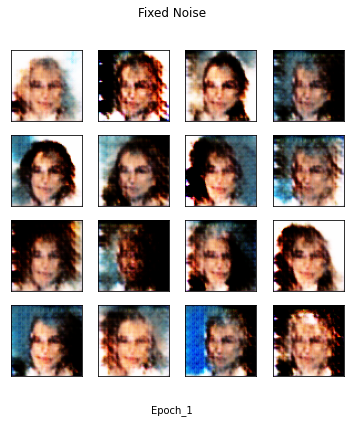

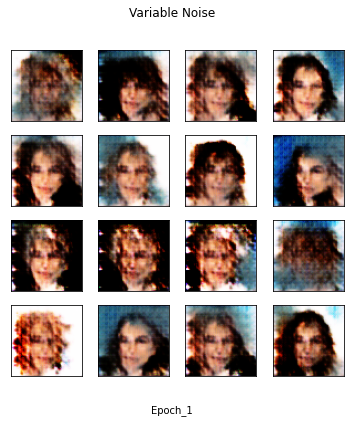

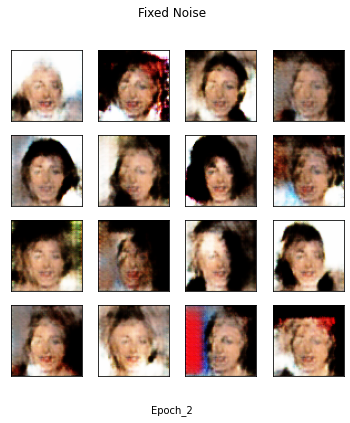

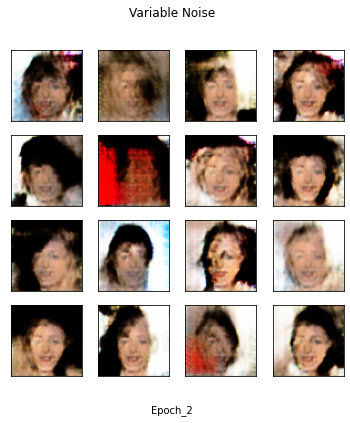

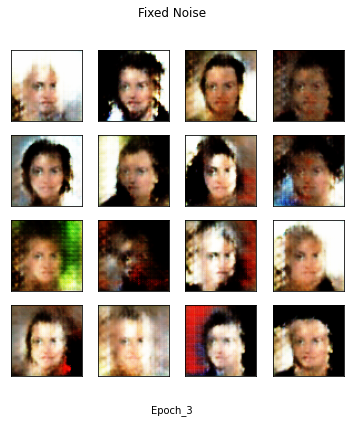

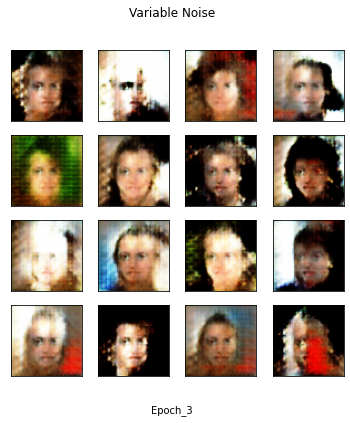

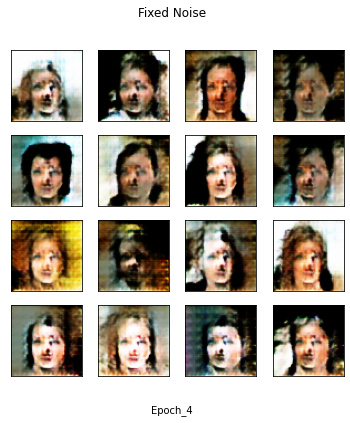

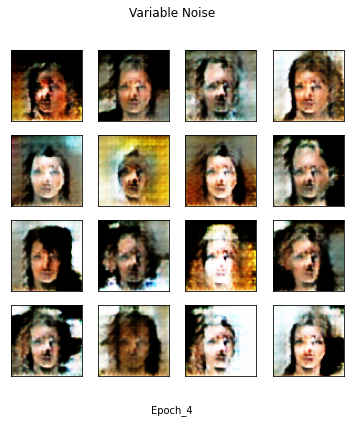

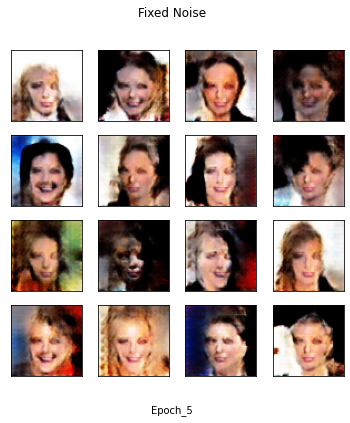

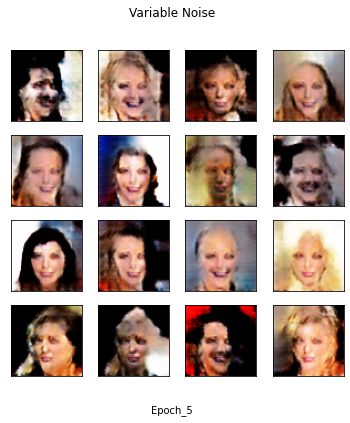

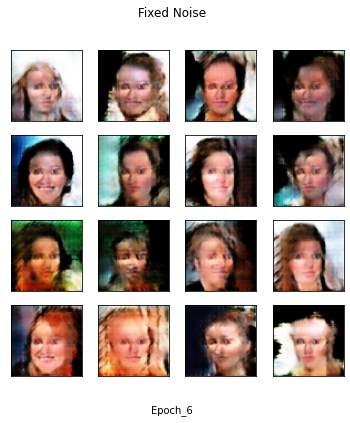

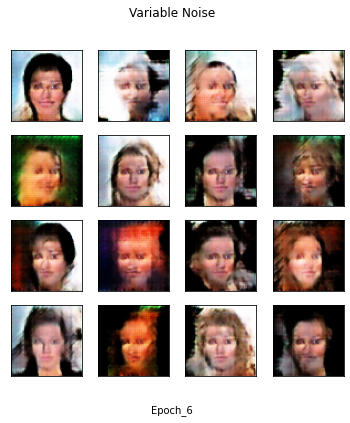

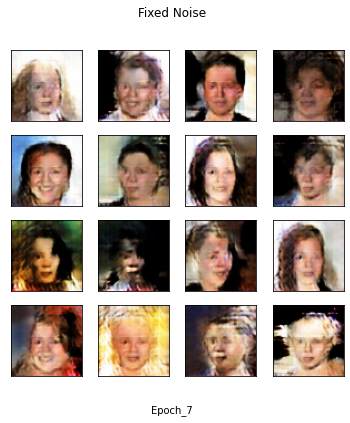

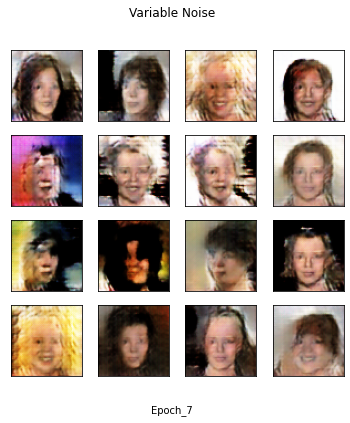

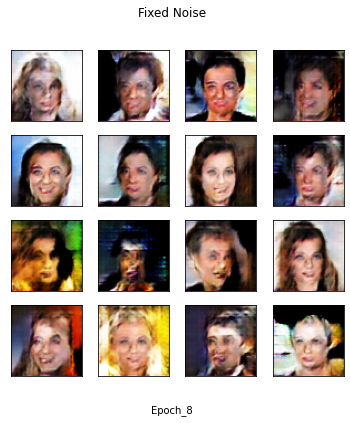

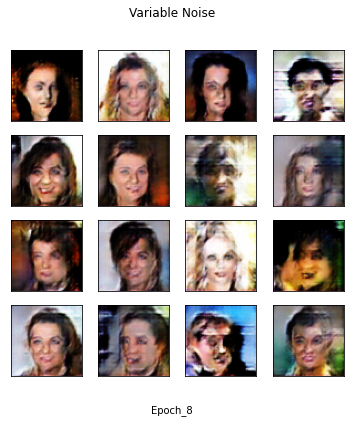

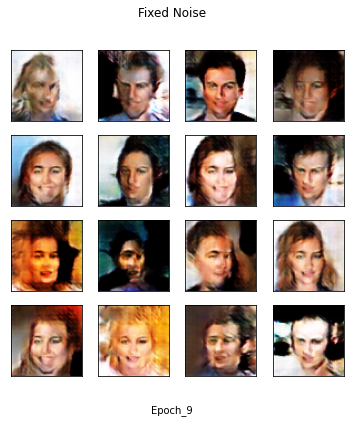

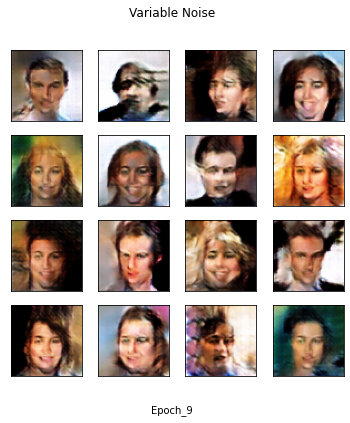

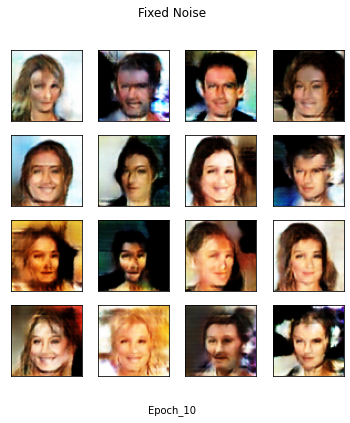

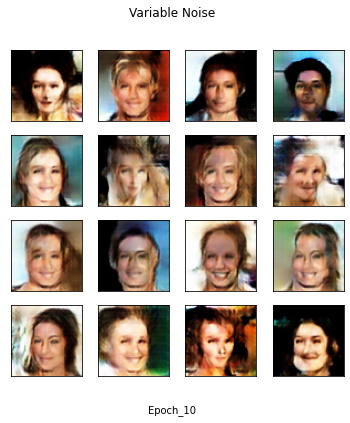

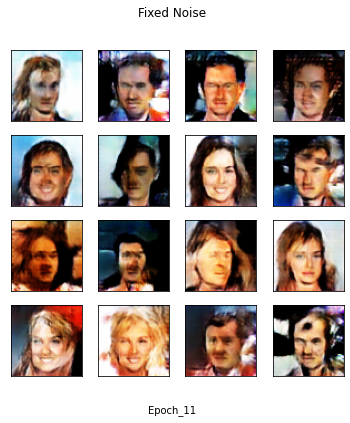

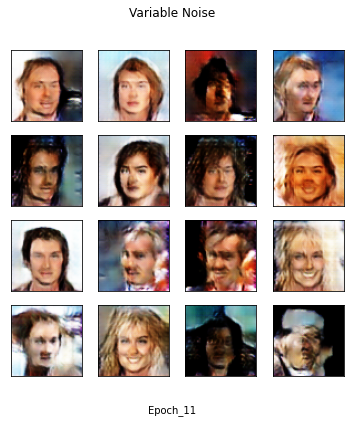

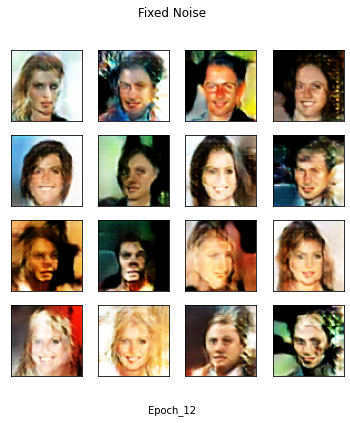

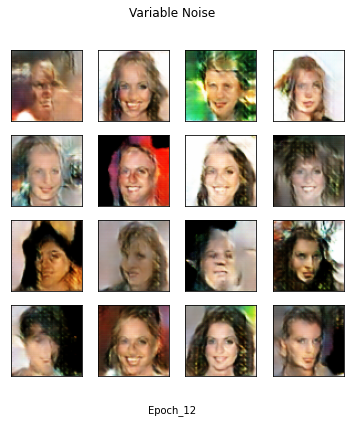

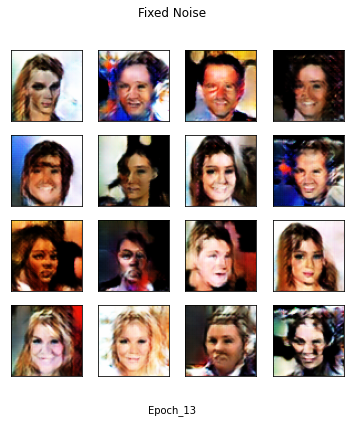

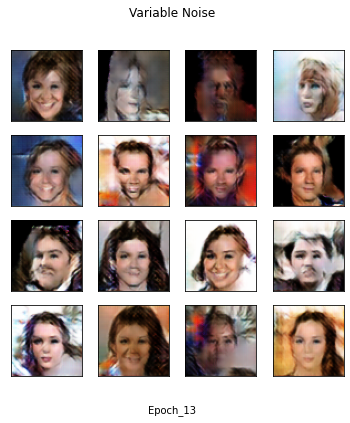

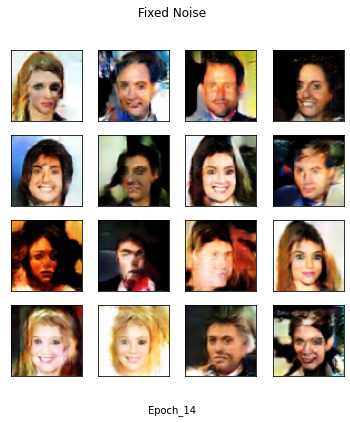

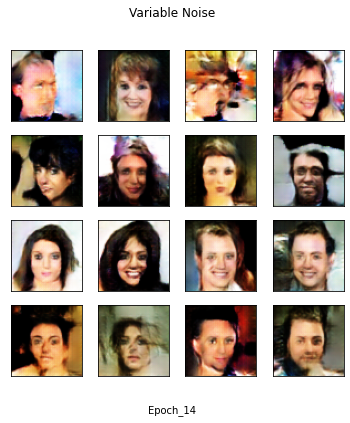

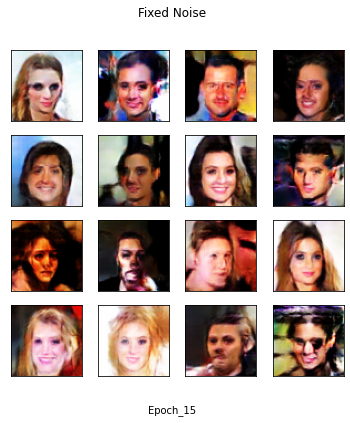

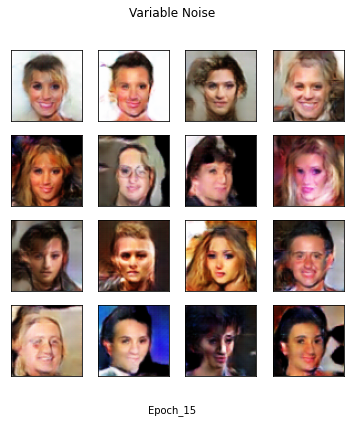

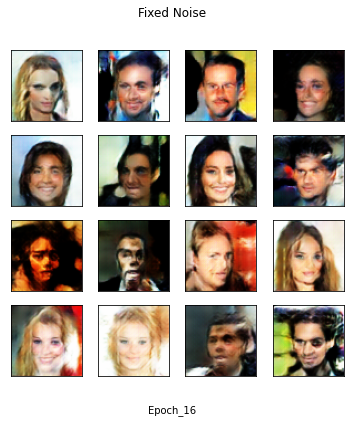

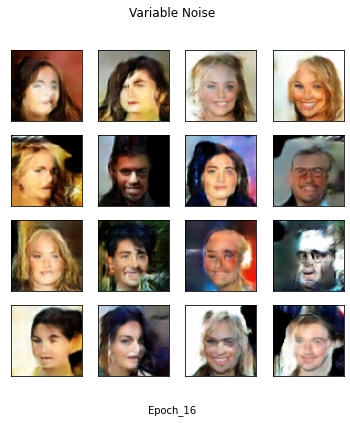

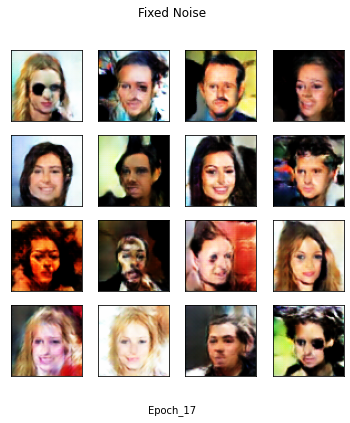

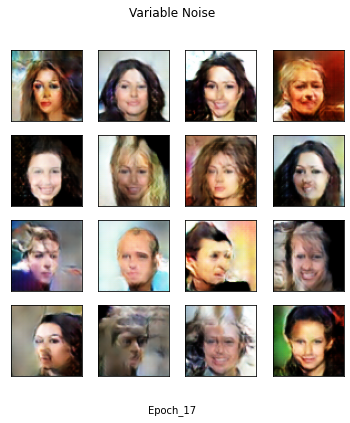

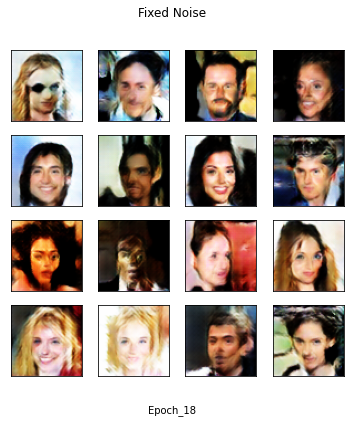

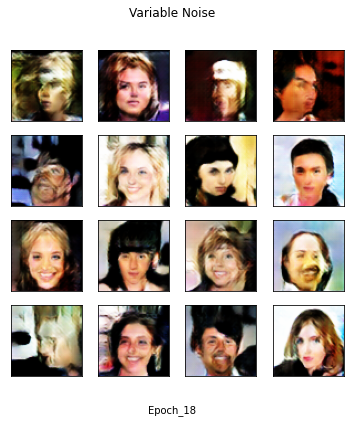

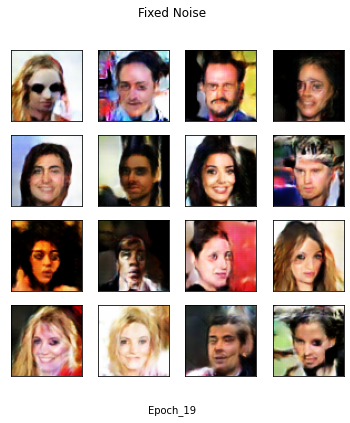

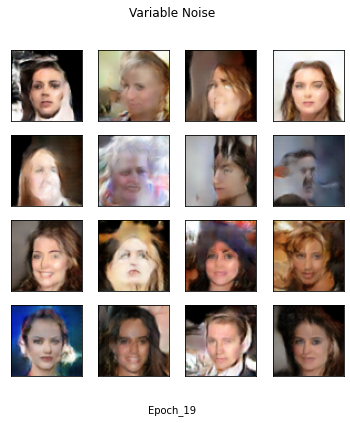

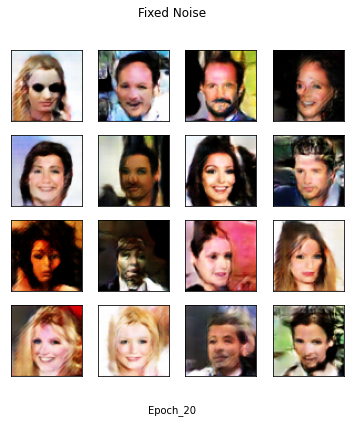

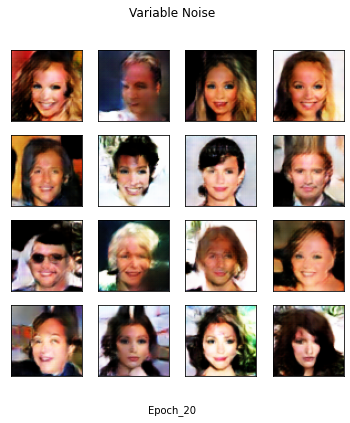

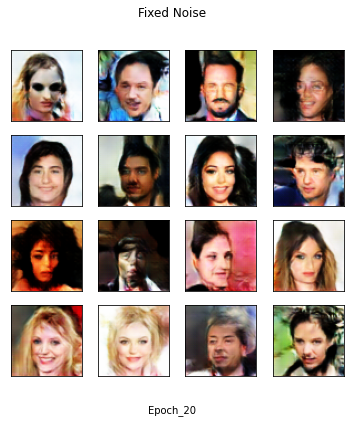

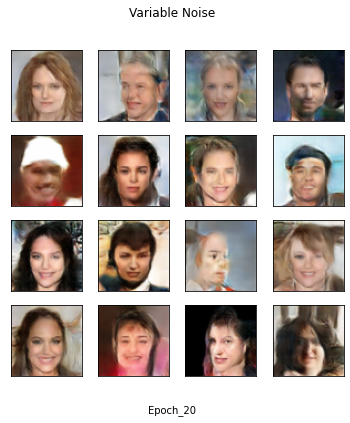

In [15]:
from torch.utils.tensorboard import SummaryWriter

netG = Generator().to(device)
netG.apply(weights_init)
netD = Discriminator().to(device)
netD.apply(weights_init)
netG.load_state_dict(torch.load("/kaggle/input/weights/epoch5_g.txt"))
netD.load_state_dict(torch.load("/kaggle/input/weights/epoch5_d.txt"))

# Setup Adam optimizers for both G and D
opt_D = torch.optim.Adam(netD.parameters(), lr=0.0002)
opt_G = torch.optim.Adam(netG.parameters(), lr=0.0002)
fixed_noise = torch.randn(16, 100, 1, 1, device=device)
max_epochs=20
writer = SummaryWriter()
save_path="./model/"
if not os.path.exists(save_path):
    os.makedirs(save_path)

for i in range(max_epochs):
  generate_images(i, "./Test", fixed_noise, 16, netG, device,True)
  generate_images(i, "./Test", fixed_noise, 16, netG, device,False)
  if i%2==0:      
      torch.save(netG.state_dict(), save_path+"epoch"+str(i)+"_g.txt")
      torch.save(netD.state_dict(), save_path+"epoch"+str(i)+"_d.txt")
  train(i,celeba_dataloader,netG,netD,opt_D,opt_G,writer,device,max_epochs)
  
generate_images(i, "./Test", fixed_noise, 16, netG, device)
generate_images(i, "./Test", fixed_noise, 16, netG, device,False)
torch.save(netG.state_dict(),"./model/epoch"+str(i)+"_g.txt")
torch.save(netD.state_dict(),"./model/epoch"+str(i)+"_d.txt")
  

In [ ]:
import os

!zip -r file.zip '/kaggle/working'

Le code ci-dessous applique votre réseau à un batch de $z$ aléatoires et affiche les images générées (et enregistre dans fake.png). 

Bonus: Réaliser le même genre d'apprentissage sur le corpus Mnist (Dataloader existant dans torch pour télécharger et charger le corpus)